In [1]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF  
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn.functional as F  
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import io
import os
import random
import pickle

In [2]:
batch_files = [f"/scratch/as20255/cifar-10-batches-py/data_batch_{i}" for i in range(1, 6)]
test_batch_file = "/scratch/as20255/cifar-10-batches-py/test_batch"
for file in batch_files + [test_batch_file]:
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
        print(f"{os.path.basename(file)}:")
        print(f"  Data shape: {data[b'data'].shape}")
        print(f"  Labels shape: {len(data[b'labels'])}, all present: {len(data[b'labels']) == data[b'data'].shape[0]}")

data_batch_1:
  Data shape: (10000, 3072)
  Labels shape: 10000, all present: True
data_batch_2:
  Data shape: (10000, 3072)
  Labels shape: 10000, all present: True
data_batch_3:
  Data shape: (10000, 3072)
  Labels shape: 10000, all present: True
data_batch_4:
  Data shape: (10000, 3072)
  Labels shape: 10000, all present: True
data_batch_5:
  Data shape: (10000, 3072)
  Labels shape: 10000, all present: True
test_batch:
  Data shape: (10000, 3072)
  Labels shape: 10000, all present: True


In [3]:
with open("/scratch/as20255/cifar_test_nolabel.pkl", 'rb') as f:
    data = pickle.load(f, encoding='bytes')
    print("cifar_test_nolabel.pkl:")
    print(f"  Data shape: {data[b'data'].shape}")
    print(f"  Labels present: {b'labels' in data}")

cifar_test_nolabel.pkl:
  Data shape: (10000, 32, 32, 3)
  Labels present: False


In [4]:
batch_files = [f"cifar-10-batches-py/data_batch_{i}" for i in range(1, 6)]
all_images, all_labels = [], []
for batch_file in batch_files:
    with open(batch_file, 'rb') as f:
        batch_data = pickle.load(f, encoding='bytes')
        all_images.append(batch_data[b'data'])
        all_labels.extend(batch_data[b'labels'])
train_images = np.vstack(all_images)
train_labels = all_labels

with open("cifar-10-batches-py/test_batch", 'rb') as f:
    val_data = pickle.load(f, encoding='bytes')
val_images = val_data[b'data']
val_labels = val_data[b'labels']

with open("cifar_test_nolabel.pkl", 'rb') as f:
    test_nolabel_data = pickle.load(f, encoding='bytes')
    
test_nolabel_images = test_nolabel_data[b'data'].astype(np.uint8)  # Already (10000, 32, 32, 3)
test_nolabel_ids = test_nolabel_data[b'ids']  

In [5]:
# Save training dataset
with h5py.File('train_dataset.h5', 'w') as f:
    f.create_dataset('images', data=train_images)
    f.create_dataset('labels', data=np.array(train_labels))

# Save validation dataset
with h5py.File('val_dataset.h5', 'w') as f:
    f.create_dataset('images', data=val_images)
    f.create_dataset('labels', data=np.array(val_labels))

# Save test dataset (store IDs instead of labels)
with h5py.File('test_dataset.h5', 'w') as f:
    f.create_dataset('images', data=test_nolabel_images)
    f.create_dataset('ids', data=np.array(test_nolabel_ids))

In [6]:
with h5py.File('train_dataset.h5', 'r') as f:
    train_images = f['images'][:]
    train_labels = f['labels'][:]
with h5py.File('val_dataset.h5', 'r') as f:
    val_images = f['images'][:]
    val_labels = f['labels'][:]
with h5py.File('test_dataset.h5', 'r') as f:
    test_images = f['images'][:]
    test_ids = f['ids'][:]

In [7]:
class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels=None, ids=None, transform=None, is_flat=True):
        self.data = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype(np.uint8) if is_flat else data.astype(np.uint8)
        self.labels = labels
        self.ids = ids if ids is not None else np.arange(len(data))
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        image = Image.fromarray(self.data[idx])
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx] if self.labels is not None else -1
        return image, label, self.ids[idx]

In [8]:
train_images_np = train_images.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
mean = np.mean(train_images_np, axis=(0, 2, 3)).tolist()  # [R, G, B]
std = np.std(train_images_np, axis=(0, 2, 3)).tolist()    # [R, G, B]
print(f"Computed Mean: {mean}")
print(f"Computed Std: {std}")

Computed Mean: [0.49140089750289917, 0.48215895891189575, 0.4465307891368866]
Computed Std: [0.2470327913761139, 0.243484228849411, 0.261587530374527]


In [9]:
print("Train images type:", type(train_images), "dtype:", train_images.dtype)
print("Train labels type:", type(train_labels), "dtype:", np.array(train_labels).dtype if isinstance(train_labels, list) else train_labels.dtype)
print("Val images type:", type(val_images), "dtype:", val_images.dtype)
print("Val labels type:", type(val_labels), "dtype:", np.array(val_labels).dtype if isinstance(val_labels, list) else val_labels.dtype)
print("Test images type:", type(test_nolabel_images), "dtype:", test_nolabel_images.dtype)
print("Test IDs type:", type(test_nolabel_ids), "dtype:", np.array(test_nolabel_ids).dtype if isinstance(test_nolabel_ids, list) else test_nolabel_ids.dtype)

Train images type: <class 'numpy.ndarray'> dtype: uint8
Train labels type: <class 'numpy.ndarray'> dtype: int64
Val images type: <class 'numpy.ndarray'> dtype: uint8
Val labels type: <class 'numpy.ndarray'> dtype: int64
Test images type: <class 'numpy.ndarray'> dtype: uint8
Test IDs type: <class 'numpy.ndarray'> dtype: int64


In [10]:
def get_train_transform(severity=1.0):
    
    base_transforms = [
        transforms.RandomCrop(32, padding=1), 
        transforms.RandomHorizontalFlip(),
    ]
    
    color_factor = min(1.3, 0.7 + 0.6 * (severity - 1.0)) 
    color_transforms = transforms.RandomChoice([
        transforms.Lambda(lambda img: TF.adjust_brightness(img, random.uniform(0.7, 1.0 + color_factor))),
        transforms.Lambda(lambda img: TF.adjust_contrast(img, random.uniform(0.7, 1.0 + color_factor))),
        transforms.Lambda(lambda img: TF.adjust_hue(img, random.uniform(-0.1 * severity, 0.1 * severity))),
        transforms.Lambda(lambda img: TF.adjust_saturation(img, random.uniform(0.7, 1.0 + color_factor))),
    ])
    
    blur_sigma = min(0.8, 0.1 + 0.7 * (severity - 1)) 
    jpeg_quality = max(50, 90 - 40 * (severity - 1))   
    pixel_scale = max(0.5, 0.9 - 0.4 * (severity - 1))
    hard_transforms = transforms.RandomChoice([
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, blur_sigma)),
        transforms.Lambda(lambda img: pixelate(img, scale=pixel_scale)),
    ])
    
    rotation_degrees = min(30, 10 * severity)  
    distortion_scale = min(0.5, 0.2 + 0.3 * (severity - 1.0)) 
    geometric_transforms = transforms.RandomChoice([
        transforms.RandomRotation(degrees=rotation_degrees),
        transforms.RandomPerspective(distortion_scale=distortion_scale, p=0.5),
    ])
    
    return transforms.Compose(
        base_transforms + [
            color_transforms,
            hard_transforms,
            geometric_transforms,
            transforms.RandomGrayscale(p=0.35 * severity),  
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ]
    )

train_transform = get_train_transform(severity=1.0)

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

train_dataset = CIFAR10Dataset(train_images, train_labels, transform=train_transform)
val_dataset = CIFAR10Dataset(val_images, val_labels, transform=val_test_transform)
test_dataset = CIFAR10Dataset(test_images, ids=test_ids, transform=val_test_transform, is_flat=False)

In [11]:
cifar10_labels = {
    0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer',
    5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'
}

In [12]:
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 50000
Validation dataset size: 10000
Test dataset size: 10000


In [13]:
def pixelate(img, scale=0.5):
    small_size = (int(32 * scale), int(32 * scale))  # e.g., 16x16
    img = img.resize(small_size, Image.NEAREST)
    return img.resize((32, 32), Image.NEAREST)

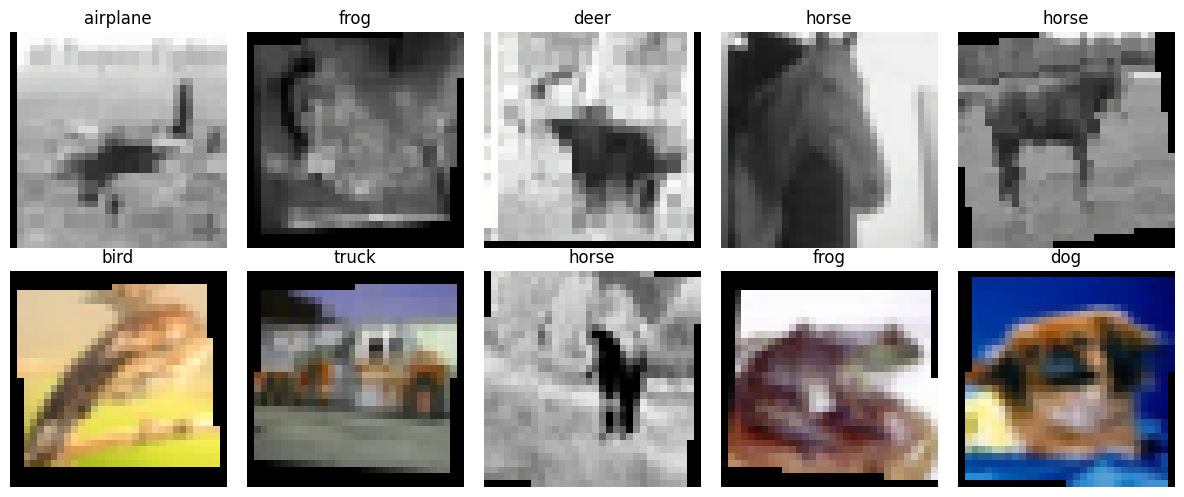

In [14]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
indices = np.random.choice(len(train_dataset), 10, replace=False)
for ax, idx in zip(axes.flatten(), indices):
    img, label, _ = train_dataset[idx]
    img_np = img.permute(1, 2, 0).numpy() * np.array(std) + np.array(mean)
    img_np = np.clip(img_np, 0, 1)
    ax.imshow(img_np)
    ax.set_title(f"{cifar10_labels[label]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

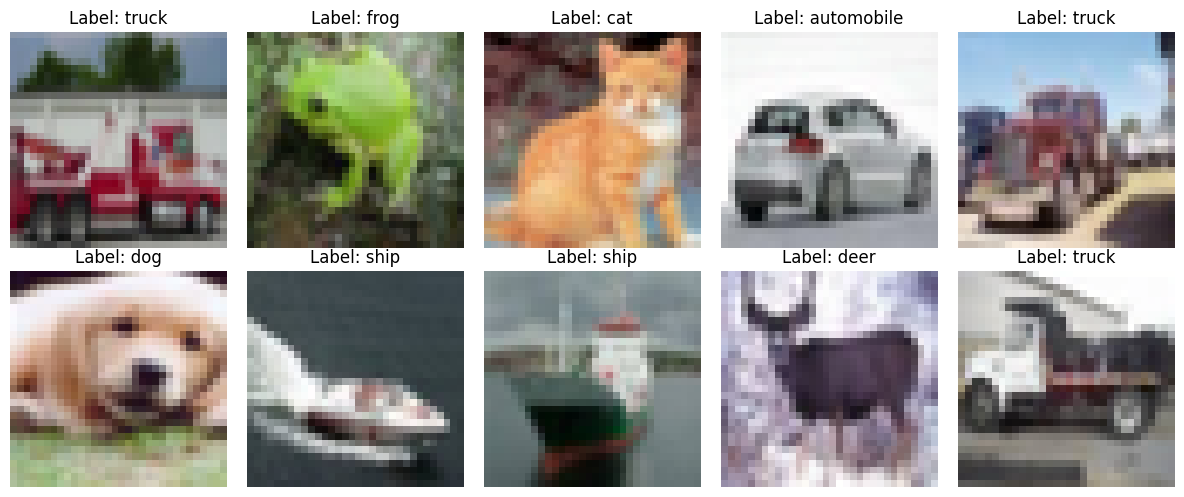

In [15]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
indices = np.random.choice(len(val_dataset), 10, replace=False)
for ax, idx in zip(axes.flatten(), indices):
    img, label, _ = val_dataset[idx]
    img_np = img.permute(1, 2, 0).numpy() * np.array(std) + np.array(mean)
    img_np = np.clip(img_np, 0, 1)
    ax.imshow(img_np)
    ax.set_title(f"Label: {cifar10_labels[label]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

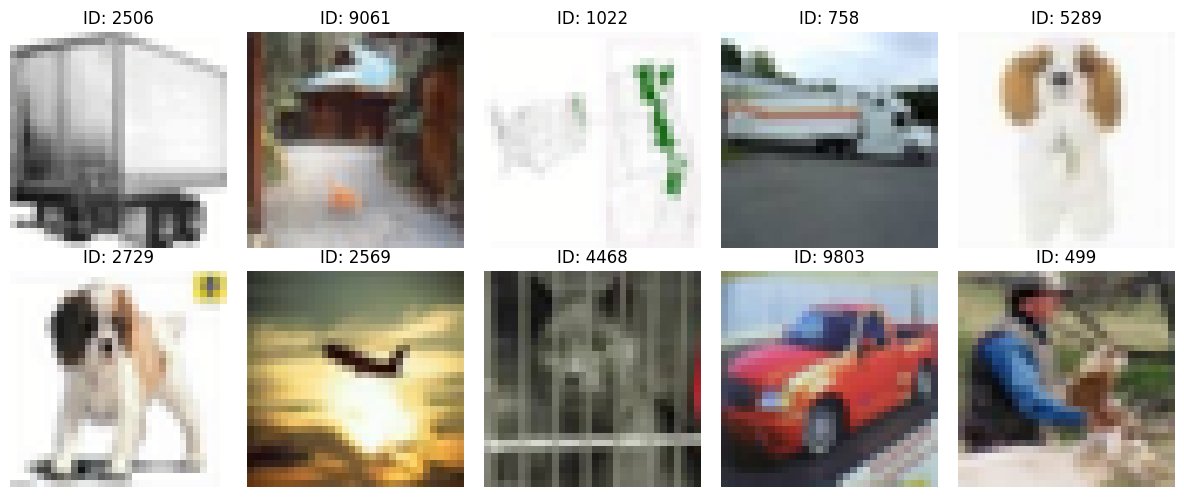

In [16]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
indices = np.random.choice(len(test_dataset), 10, replace=False)
for ax, idx in zip(axes.flatten(), indices):
    img, _, id = test_dataset[idx]
    img_np = img.permute(1, 2, 0).numpy() * np.array(std) + np.array(mean)
    img_np = np.clip(img_np, 0, 1)
    ax.imshow(img_np)
    ax.set_title(f"ID: {id}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [17]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

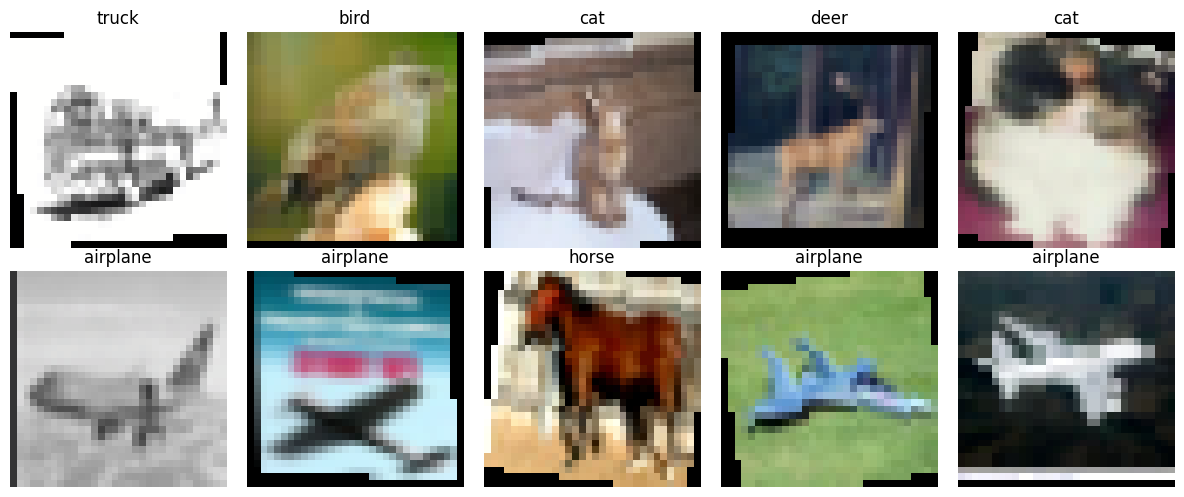

In [18]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
indices = np.random.choice(len(train_dataset), 10, replace=False)
for ax, idx in zip(axes.flatten(), indices):
    img, label, _ = train_dataset[idx]
    img_np = img.permute(1, 2, 0).numpy() * np.array(std) + np.array(mean)
    img_np = np.clip(img_np, 0, 1)
    ax.imshow(img_np)
    ax.set_title(f"{cifar10_labels[label]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import os

In [20]:
class SEBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, reduction=16):
        super(SEBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_channels, out_channels // reduction, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels // reduction, out_channels, kernel_size=1),
            nn.Sigmoid()
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        se = self.se(out)
        out = out * se
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [21]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 48, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 96, num_blocks[1], stride=1)
        self.layer3 = self._make_layer(block, 144, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 192, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(192, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(SEBasicBlock, [3, 4, 6, 3]).to(device)

In [23]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 48, 32, 32]           6,912
       BatchNorm2d-4           [-1, 48, 32, 32]              96
            Conv2d-5           [-1, 48, 32, 32]          20,736
       BatchNorm2d-6           [-1, 48, 32, 32]              96
 AdaptiveAvgPool2d-7             [-1, 48, 1, 1]               0
            Conv2d-8              [-1, 3, 1, 1]             147
              ReLU-9              [-1, 3, 1, 1]               0
           Conv2d-10             [-1, 48, 1, 1]             192
          Sigmoid-11             [-1, 48, 1, 1]               0
           Conv2d-12           [-1, 48, 32, 32]             768
      BatchNorm2d-13           [-1, 48, 32, 32]              96
     SEBasicBlock-14           [-1, 48,

In [25]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

checkpoint_path = "final_model_03-14.pth" 
severity = 1.0  
max_severity = 1.5  
acc_gap_threshold = 2.0  
best_val_loss = float('inf')
start_epoch = 0
num_epochs = 150

criterion = nn.CrossEntropyLoss(label_smoothing=0.15)
optimizer = optim.SGD(model.parameters(), lr=0.075, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=10, min_lr=1e-6
)
model.to(device)

def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    return torch.clamp(perturbed_image, 0, 1)

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    severity = checkpoint['severity']
    train_dataset.transform = get_train_transform(severity=severity)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}, best val loss: {best_val_loss:.4f}, severity: {severity:.2f}")
else:
    print("No checkpoint found, starting training from scratch.")

for epoch in range(start_epoch, num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for images, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Adversarial training (20% of batches)
        if random.random() < 0.2:
            images.requires_grad = True
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward(retain_graph=True)
            perturbed_images = fgsm_attack(images, epsilon=0.01, data_grad=images.grad.data)
            optimizer.zero_grad()
            outputs = model(perturbed_images)
            loss = criterion(outputs, labels)
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item() * labels.size(0)
        _, preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_total += labels.size(0)

    train_loss /= train_total
    train_acc = 100. * train_correct / train_total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels, _ in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            _, preds = outputs.max(1)
            val_correct += preds.eq(labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = 100. * val_correct / val_total

    scheduler.step(val_loss)

    acc_gap = train_acc - val_acc
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% | Acc Gap: {acc_gap:.2f}% | Transform Severity: {severity:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_loss': best_val_loss,
            'severity': severity
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"Model checkpoint saved at epoch {epoch+1} with val loss {val_loss:.4f}")

    if acc_gap > acc_gap_threshold and severity < max_severity:
        severity = min(severity + 0.05 * (acc_gap - acc_gap_threshold), max_severity)
        train_dataset.transform = get_train_transform(severity=severity)
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
        print(f"Acc gap {acc_gap:.2f}% > {acc_gap_threshold}, increased transform severity to {severity:.2f}")

No checkpoint found, starting training from scratch.


Epoch 1/150 - Training: 100%|██████████| 782/782 [00:34<00:00, 22.97it/s]


Epoch [1/150] | Train Loss: 1.2424, Train Acc: 73.41% | Val Loss: 1.0876, Val Acc: 81.45% | Acc Gap: -8.04% | Transform Severity: 1.00
Model checkpoint saved at epoch 1 with val loss 1.0876


Epoch 2/150 - Training: 100%|██████████| 782/782 [00:33<00:00, 23.23it/s]


Epoch [2/150] | Train Loss: 1.2127, Train Acc: 74.68% | Val Loss: 1.1017, Val Acc: 80.50% | Acc Gap: -5.82% | Transform Severity: 1.00


Epoch 3/150 - Training: 100%|██████████| 782/782 [00:36<00:00, 21.23it/s]


Epoch [3/150] | Train Loss: 1.1858, Train Acc: 76.11% | Val Loss: 1.0989, Val Acc: 80.29% | Acc Gap: -4.18% | Transform Severity: 1.00


Epoch 4/150 - Training: 100%|██████████| 782/782 [00:35<00:00, 22.28it/s]


Epoch [4/150] | Train Loss: 1.1668, Train Acc: 77.12% | Val Loss: 1.0552, Val Acc: 82.03% | Acc Gap: -4.91% | Transform Severity: 1.00
Model checkpoint saved at epoch 4 with val loss 1.0552


Epoch 5/150 - Training: 100%|██████████| 782/782 [00:35<00:00, 21.91it/s]


Epoch [5/150] | Train Loss: 1.1484, Train Acc: 78.05% | Val Loss: 1.0138, Val Acc: 84.72% | Acc Gap: -6.67% | Transform Severity: 1.00
Model checkpoint saved at epoch 5 with val loss 1.0138


Epoch 6/150 - Training: 100%|██████████| 782/782 [00:35<00:00, 21.75it/s]


Epoch [6/150] | Train Loss: 1.1290, Train Acc: 78.94% | Val Loss: 1.0437, Val Acc: 83.36% | Acc Gap: -4.42% | Transform Severity: 1.00


Epoch 7/150 - Training: 100%|██████████| 782/782 [00:34<00:00, 22.68it/s]


Epoch [7/150] | Train Loss: 1.1179, Train Acc: 79.46% | Val Loss: 1.0609, Val Acc: 82.43% | Acc Gap: -2.97% | Transform Severity: 1.00


Epoch 8/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.17it/s]


Epoch [8/150] | Train Loss: 1.1010, Train Acc: 80.26% | Val Loss: 0.9978, Val Acc: 85.33% | Acc Gap: -5.07% | Transform Severity: 1.00
Model checkpoint saved at epoch 8 with val loss 0.9978


Epoch 9/150 - Training: 100%|██████████| 782/782 [00:33<00:00, 23.39it/s]


Epoch [9/150] | Train Loss: 1.0930, Train Acc: 80.64% | Val Loss: 1.0127, Val Acc: 84.72% | Acc Gap: -4.08% | Transform Severity: 1.00


Epoch 10/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.99it/s]


Epoch [10/150] | Train Loss: 1.0833, Train Acc: 81.28% | Val Loss: 0.9528, Val Acc: 87.50% | Acc Gap: -6.22% | Transform Severity: 1.00
Model checkpoint saved at epoch 10 with val loss 0.9528


Epoch 11/150 - Training: 100%|██████████| 782/782 [00:30<00:00, 25.54it/s]


Epoch [11/150] | Train Loss: 1.0726, Train Acc: 81.78% | Val Loss: 0.9712, Val Acc: 86.95% | Acc Gap: -5.17% | Transform Severity: 1.00


Epoch 12/150 - Training: 100%|██████████| 782/782 [00:33<00:00, 23.34it/s]


Epoch [12/150] | Train Loss: 1.0676, Train Acc: 81.98% | Val Loss: 0.9544, Val Acc: 87.32% | Acc Gap: -5.34% | Transform Severity: 1.00


Epoch 13/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.14it/s]


Epoch [13/150] | Train Loss: 1.0609, Train Acc: 82.37% | Val Loss: 0.9454, Val Acc: 87.86% | Acc Gap: -5.49% | Transform Severity: 1.00
Model checkpoint saved at epoch 13 with val loss 0.9454


Epoch 14/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.36it/s]


Epoch [14/150] | Train Loss: 1.0606, Train Acc: 82.41% | Val Loss: 0.9412, Val Acc: 87.94% | Acc Gap: -5.53% | Transform Severity: 1.00
Model checkpoint saved at epoch 14 with val loss 0.9412


Epoch 15/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 25.04it/s]


Epoch [15/150] | Train Loss: 1.0452, Train Acc: 82.99% | Val Loss: 0.9564, Val Acc: 87.39% | Acc Gap: -4.40% | Transform Severity: 1.00


Epoch 16/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 23.94it/s]


Epoch [16/150] | Train Loss: 1.0500, Train Acc: 82.77% | Val Loss: 0.9531, Val Acc: 87.53% | Acc Gap: -4.76% | Transform Severity: 1.00


Epoch 17/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.94it/s]


Epoch [17/150] | Train Loss: 1.0325, Train Acc: 83.70% | Val Loss: 0.9311, Val Acc: 88.57% | Acc Gap: -4.87% | Transform Severity: 1.00
Model checkpoint saved at epoch 17 with val loss 0.9311


Epoch 18/150 - Training: 100%|██████████| 782/782 [00:33<00:00, 23.66it/s]


Epoch [18/150] | Train Loss: 1.0350, Train Acc: 83.69% | Val Loss: 0.9501, Val Acc: 87.84% | Acc Gap: -4.15% | Transform Severity: 1.00


Epoch 19/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.89it/s]


Epoch [19/150] | Train Loss: 1.0255, Train Acc: 83.97% | Val Loss: 0.9619, Val Acc: 86.92% | Acc Gap: -2.95% | Transform Severity: 1.00


Epoch 20/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.19it/s]


Epoch [20/150] | Train Loss: 1.0265, Train Acc: 83.96% | Val Loss: 0.9532, Val Acc: 87.41% | Acc Gap: -3.45% | Transform Severity: 1.00


Epoch 21/150 - Training: 100%|██████████| 782/782 [00:33<00:00, 23.16it/s]


Epoch [21/150] | Train Loss: 1.0156, Train Acc: 84.62% | Val Loss: 0.9421, Val Acc: 88.01% | Acc Gap: -3.39% | Transform Severity: 1.00


Epoch 22/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 23.97it/s]


Epoch [22/150] | Train Loss: 1.0220, Train Acc: 84.13% | Val Loss: 0.9366, Val Acc: 88.26% | Acc Gap: -4.13% | Transform Severity: 1.00


Epoch 23/150 - Training: 100%|██████████| 782/782 [00:30<00:00, 25.50it/s]


Epoch [23/150] | Train Loss: 1.0092, Train Acc: 84.92% | Val Loss: 0.9399, Val Acc: 88.16% | Acc Gap: -3.24% | Transform Severity: 1.00


Epoch 24/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.15it/s]


Epoch [24/150] | Train Loss: 1.0148, Train Acc: 84.72% | Val Loss: 0.9290, Val Acc: 88.73% | Acc Gap: -4.01% | Transform Severity: 1.00
Model checkpoint saved at epoch 24 with val loss 0.9290


Epoch 25/150 - Training: 100%|██████████| 782/782 [00:30<00:00, 25.46it/s]


Epoch [25/150] | Train Loss: 1.0087, Train Acc: 84.96% | Val Loss: 0.9394, Val Acc: 88.12% | Acc Gap: -3.16% | Transform Severity: 1.00


Epoch 26/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.76it/s]


Epoch [26/150] | Train Loss: 1.0042, Train Acc: 85.20% | Val Loss: 0.9528, Val Acc: 87.62% | Acc Gap: -2.42% | Transform Severity: 1.00


Epoch 27/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 23.88it/s]


Epoch [27/150] | Train Loss: 1.0014, Train Acc: 85.33% | Val Loss: 0.9157, Val Acc: 89.11% | Acc Gap: -3.78% | Transform Severity: 1.00
Model checkpoint saved at epoch 27 with val loss 0.9157


Epoch 28/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.91it/s]


Epoch [28/150] | Train Loss: 1.0053, Train Acc: 85.21% | Val Loss: 0.9384, Val Acc: 88.35% | Acc Gap: -3.14% | Transform Severity: 1.00


Epoch 29/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.94it/s]


Epoch [29/150] | Train Loss: 0.9950, Train Acc: 85.63% | Val Loss: 0.9341, Val Acc: 88.67% | Acc Gap: -3.04% | Transform Severity: 1.00


Epoch 30/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.38it/s]


Epoch [30/150] | Train Loss: 1.0055, Train Acc: 85.01% | Val Loss: 0.9252, Val Acc: 88.65% | Acc Gap: -3.64% | Transform Severity: 1.00


Epoch 31/150 - Training: 100%|██████████| 782/782 [00:33<00:00, 23.62it/s]


Epoch [31/150] | Train Loss: 0.9952, Train Acc: 85.64% | Val Loss: 0.9202, Val Acc: 88.81% | Acc Gap: -3.17% | Transform Severity: 1.00


Epoch 32/150 - Training: 100%|██████████| 782/782 [00:33<00:00, 23.24it/s]


Epoch [32/150] | Train Loss: 0.9910, Train Acc: 85.78% | Val Loss: 0.9483, Val Acc: 87.89% | Acc Gap: -2.11% | Transform Severity: 1.00


Epoch 33/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.15it/s]


Epoch [33/150] | Train Loss: 0.9952, Train Acc: 85.58% | Val Loss: 0.8989, Val Acc: 89.93% | Acc Gap: -4.35% | Transform Severity: 1.00
Model checkpoint saved at epoch 33 with val loss 0.8989


Epoch 34/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.63it/s]


Epoch [34/150] | Train Loss: 0.9914, Train Acc: 85.76% | Val Loss: 0.9341, Val Acc: 88.33% | Acc Gap: -2.57% | Transform Severity: 1.00


Epoch 35/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.79it/s]


Epoch [35/150] | Train Loss: 0.9885, Train Acc: 85.85% | Val Loss: 0.9286, Val Acc: 88.68% | Acc Gap: -2.83% | Transform Severity: 1.00


Epoch 36/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.63it/s]


Epoch [36/150] | Train Loss: 0.9875, Train Acc: 85.82% | Val Loss: 0.9060, Val Acc: 89.79% | Acc Gap: -3.97% | Transform Severity: 1.00


Epoch 37/150 - Training: 100%|██████████| 782/782 [00:33<00:00, 23.66it/s]


Epoch [37/150] | Train Loss: 0.9889, Train Acc: 85.83% | Val Loss: 0.9167, Val Acc: 89.29% | Acc Gap: -3.46% | Transform Severity: 1.00


Epoch 38/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.51it/s]


Epoch [38/150] | Train Loss: 0.9964, Train Acc: 85.54% | Val Loss: 0.9095, Val Acc: 89.35% | Acc Gap: -3.81% | Transform Severity: 1.00


Epoch 39/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.38it/s]


Epoch [39/150] | Train Loss: 0.9820, Train Acc: 86.29% | Val Loss: 0.9127, Val Acc: 89.60% | Acc Gap: -3.31% | Transform Severity: 1.00


Epoch 40/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.12it/s]


Epoch [40/150] | Train Loss: 0.9856, Train Acc: 86.09% | Val Loss: 0.8912, Val Acc: 90.56% | Acc Gap: -4.47% | Transform Severity: 1.00
Model checkpoint saved at epoch 40 with val loss 0.8912


Epoch 41/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.77it/s]


Epoch [41/150] | Train Loss: 0.9714, Train Acc: 86.77% | Val Loss: 0.9081, Val Acc: 89.90% | Acc Gap: -3.13% | Transform Severity: 1.00


Epoch 42/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.71it/s]


Epoch [42/150] | Train Loss: 0.9851, Train Acc: 85.96% | Val Loss: 0.9263, Val Acc: 88.76% | Acc Gap: -2.80% | Transform Severity: 1.00


Epoch 43/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.04it/s]


Epoch [43/150] | Train Loss: 0.9669, Train Acc: 86.99% | Val Loss: 0.9273, Val Acc: 88.89% | Acc Gap: -1.90% | Transform Severity: 1.00


Epoch 44/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.15it/s]


Epoch [44/150] | Train Loss: 0.9738, Train Acc: 86.52% | Val Loss: 0.8955, Val Acc: 90.31% | Acc Gap: -3.79% | Transform Severity: 1.00


Epoch 45/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 25.16it/s]


Epoch [45/150] | Train Loss: 0.9679, Train Acc: 86.92% | Val Loss: 0.8863, Val Acc: 90.54% | Acc Gap: -3.62% | Transform Severity: 1.00
Model checkpoint saved at epoch 45 with val loss 0.8863


Epoch 46/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 25.16it/s]


Epoch [46/150] | Train Loss: 0.9616, Train Acc: 87.15% | Val Loss: 0.9030, Val Acc: 89.90% | Acc Gap: -2.75% | Transform Severity: 1.00


Epoch 47/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.80it/s]


Epoch [47/150] | Train Loss: 0.9738, Train Acc: 86.63% | Val Loss: 0.9057, Val Acc: 89.72% | Acc Gap: -3.09% | Transform Severity: 1.00


Epoch 48/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.26it/s]


Epoch [48/150] | Train Loss: 0.9631, Train Acc: 87.07% | Val Loss: 0.8966, Val Acc: 90.00% | Acc Gap: -2.93% | Transform Severity: 1.00


Epoch 49/150 - Training: 100%|██████████| 782/782 [00:34<00:00, 22.72it/s]


Epoch [49/150] | Train Loss: 0.9652, Train Acc: 87.13% | Val Loss: 0.9112, Val Acc: 89.36% | Acc Gap: -2.23% | Transform Severity: 1.00


Epoch 50/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.20it/s]


Epoch [50/150] | Train Loss: 0.9692, Train Acc: 86.87% | Val Loss: 0.9154, Val Acc: 89.25% | Acc Gap: -2.38% | Transform Severity: 1.00


Epoch 51/150 - Training: 100%|██████████| 782/782 [00:35<00:00, 22.29it/s]


Epoch [51/150] | Train Loss: 0.9687, Train Acc: 86.94% | Val Loss: 0.9238, Val Acc: 89.02% | Acc Gap: -2.08% | Transform Severity: 1.00


Epoch 52/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.59it/s]


Epoch [52/150] | Train Loss: 0.9615, Train Acc: 87.19% | Val Loss: 0.8853, Val Acc: 90.73% | Acc Gap: -3.54% | Transform Severity: 1.00
Model checkpoint saved at epoch 52 with val loss 0.8853


Epoch 53/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.30it/s]


Epoch [53/150] | Train Loss: 0.9633, Train Acc: 87.11% | Val Loss: 0.8838, Val Acc: 90.68% | Acc Gap: -3.57% | Transform Severity: 1.00
Model checkpoint saved at epoch 53 with val loss 0.8838


Epoch 54/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.30it/s]


Epoch [54/150] | Train Loss: 0.9544, Train Acc: 87.53% | Val Loss: 0.9019, Val Acc: 90.17% | Acc Gap: -2.64% | Transform Severity: 1.00


Epoch 55/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 23.70it/s]


Epoch [55/150] | Train Loss: 0.9549, Train Acc: 87.51% | Val Loss: 0.8943, Val Acc: 90.26% | Acc Gap: -2.75% | Transform Severity: 1.00


Epoch 56/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 25.15it/s]


Epoch [56/150] | Train Loss: 0.9625, Train Acc: 87.15% | Val Loss: 0.8972, Val Acc: 89.99% | Acc Gap: -2.84% | Transform Severity: 1.00


Epoch 57/150 - Training: 100%|██████████| 782/782 [00:33<00:00, 23.44it/s]


Epoch [57/150] | Train Loss: 0.9655, Train Acc: 87.08% | Val Loss: 0.8963, Val Acc: 90.09% | Acc Gap: -3.01% | Transform Severity: 1.00


Epoch 58/150 - Training: 100%|██████████| 782/782 [00:33<00:00, 23.33it/s]


Epoch [58/150] | Train Loss: 0.9550, Train Acc: 87.36% | Val Loss: 0.8958, Val Acc: 89.99% | Acc Gap: -2.63% | Transform Severity: 1.00


Epoch 59/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.36it/s]


Epoch [59/150] | Train Loss: 0.9659, Train Acc: 87.00% | Val Loss: 0.9154, Val Acc: 89.35% | Acc Gap: -2.35% | Transform Severity: 1.00


Epoch 60/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 23.98it/s]


Epoch [60/150] | Train Loss: 0.9566, Train Acc: 87.34% | Val Loss: 0.8986, Val Acc: 89.97% | Acc Gap: -2.63% | Transform Severity: 1.00


Epoch 61/150 - Training: 100%|██████████| 782/782 [00:34<00:00, 22.61it/s]


Epoch [61/150] | Train Loss: 0.9639, Train Acc: 87.09% | Val Loss: 0.9103, Val Acc: 89.56% | Acc Gap: -2.47% | Transform Severity: 1.00


Epoch 62/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.17it/s]


Epoch [62/150] | Train Loss: 0.9514, Train Acc: 87.71% | Val Loss: 0.9192, Val Acc: 89.37% | Acc Gap: -1.66% | Transform Severity: 1.00


Epoch 63/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 23.70it/s]


Epoch [63/150] | Train Loss: 0.9514, Train Acc: 87.59% | Val Loss: 0.8779, Val Acc: 91.38% | Acc Gap: -3.79% | Transform Severity: 1.00
Model checkpoint saved at epoch 63 with val loss 0.8779


Epoch 64/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 23.85it/s]


Epoch [64/150] | Train Loss: 0.9586, Train Acc: 87.32% | Val Loss: 0.9122, Val Acc: 89.49% | Acc Gap: -2.17% | Transform Severity: 1.00


Epoch 65/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.26it/s]


Epoch [65/150] | Train Loss: 0.9608, Train Acc: 87.20% | Val Loss: 0.8929, Val Acc: 90.36% | Acc Gap: -3.16% | Transform Severity: 1.00


Epoch 66/150 - Training: 100%|██████████| 782/782 [00:33<00:00, 23.23it/s]


Epoch [66/150] | Train Loss: 0.9477, Train Acc: 88.03% | Val Loss: 0.8890, Val Acc: 90.59% | Acc Gap: -2.56% | Transform Severity: 1.00


Epoch 67/150 - Training: 100%|██████████| 782/782 [00:33<00:00, 23.43it/s]


Epoch [67/150] | Train Loss: 0.9576, Train Acc: 87.39% | Val Loss: 0.8840, Val Acc: 90.73% | Acc Gap: -3.34% | Transform Severity: 1.00


Epoch 68/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.23it/s]


Epoch [68/150] | Train Loss: 0.9509, Train Acc: 87.84% | Val Loss: 0.8792, Val Acc: 91.10% | Acc Gap: -3.26% | Transform Severity: 1.00


Epoch 69/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 25.02it/s]


Epoch [69/150] | Train Loss: 0.9554, Train Acc: 87.38% | Val Loss: 0.9127, Val Acc: 89.65% | Acc Gap: -2.27% | Transform Severity: 1.00


Epoch 70/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 25.17it/s]


Epoch [70/150] | Train Loss: 0.9457, Train Acc: 88.07% | Val Loss: 0.8916, Val Acc: 90.54% | Acc Gap: -2.47% | Transform Severity: 1.00


Epoch 71/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.87it/s]


Epoch [71/150] | Train Loss: 0.9453, Train Acc: 87.99% | Val Loss: 0.8877, Val Acc: 90.65% | Acc Gap: -2.66% | Transform Severity: 1.00


Epoch 72/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.41it/s]


Epoch [72/150] | Train Loss: 0.9471, Train Acc: 87.98% | Val Loss: 0.8776, Val Acc: 91.10% | Acc Gap: -3.12% | Transform Severity: 1.00
Model checkpoint saved at epoch 72 with val loss 0.8776


Epoch 73/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 25.10it/s]


Epoch [73/150] | Train Loss: 0.9423, Train Acc: 88.26% | Val Loss: 0.9098, Val Acc: 89.64% | Acc Gap: -1.38% | Transform Severity: 1.00


Epoch 74/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.34it/s]


Epoch [74/150] | Train Loss: 0.9556, Train Acc: 87.46% | Val Loss: 0.8834, Val Acc: 90.79% | Acc Gap: -3.33% | Transform Severity: 1.00


Epoch 75/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.56it/s]


Epoch [75/150] | Train Loss: 0.9479, Train Acc: 87.93% | Val Loss: 0.8851, Val Acc: 90.61% | Acc Gap: -2.68% | Transform Severity: 1.00


Epoch 76/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.30it/s]


Epoch [76/150] | Train Loss: 0.9435, Train Acc: 88.07% | Val Loss: 0.8956, Val Acc: 90.27% | Acc Gap: -2.20% | Transform Severity: 1.00


Epoch 77/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.04it/s]


Epoch [77/150] | Train Loss: 0.9528, Train Acc: 87.66% | Val Loss: 0.8930, Val Acc: 90.44% | Acc Gap: -2.78% | Transform Severity: 1.00


Epoch 78/150 - Training: 100%|██████████| 782/782 [00:34<00:00, 22.82it/s]


Epoch [78/150] | Train Loss: 0.9418, Train Acc: 88.34% | Val Loss: 0.9120, Val Acc: 89.38% | Acc Gap: -1.04% | Transform Severity: 1.00


Epoch 79/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 23.90it/s]


Epoch [79/150] | Train Loss: 0.9510, Train Acc: 87.80% | Val Loss: 0.9514, Val Acc: 87.73% | Acc Gap: 0.07% | Transform Severity: 1.00


Epoch 80/150 - Training: 100%|██████████| 782/782 [00:30<00:00, 25.48it/s]


Epoch [80/150] | Train Loss: 0.9341, Train Acc: 88.58% | Val Loss: 0.8796, Val Acc: 90.75% | Acc Gap: -2.17% | Transform Severity: 1.00


Epoch 81/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.45it/s]


Epoch [81/150] | Train Loss: 0.9458, Train Acc: 88.07% | Val Loss: 0.9096, Val Acc: 89.80% | Acc Gap: -1.73% | Transform Severity: 1.00


Epoch 82/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.44it/s]


Epoch [82/150] | Train Loss: 0.9464, Train Acc: 87.96% | Val Loss: 0.9229, Val Acc: 89.11% | Acc Gap: -1.15% | Transform Severity: 1.00


Epoch 83/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.44it/s]


Epoch [83/150] | Train Loss: 0.9444, Train Acc: 88.03% | Val Loss: 0.8839, Val Acc: 90.56% | Acc Gap: -2.53% | Transform Severity: 1.00


Epoch 84/150 - Training: 100%|██████████| 782/782 [00:30<00:00, 25.34it/s]


Epoch [84/150] | Train Loss: 0.8634, Train Acc: 92.01% | Val Loss: 0.8152, Val Acc: 94.00% | Acc Gap: -1.99% | Transform Severity: 1.00
Model checkpoint saved at epoch 84 with val loss 0.8152


Epoch 85/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.33it/s]


Epoch [85/150] | Train Loss: 0.8374, Train Acc: 93.37% | Val Loss: 0.8115, Val Acc: 94.21% | Acc Gap: -0.84% | Transform Severity: 1.00
Model checkpoint saved at epoch 85 with val loss 0.8115


Epoch 86/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.21it/s]


Epoch [86/150] | Train Loss: 0.8308, Train Acc: 93.71% | Val Loss: 0.8045, Val Acc: 94.42% | Acc Gap: -0.71% | Transform Severity: 1.00
Model checkpoint saved at epoch 86 with val loss 0.8045


Epoch 87/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.66it/s]


Epoch [87/150] | Train Loss: 0.8259, Train Acc: 93.91% | Val Loss: 0.8028, Val Acc: 94.74% | Acc Gap: -0.83% | Transform Severity: 1.00
Model checkpoint saved at epoch 87 with val loss 0.8028


Epoch 88/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.94it/s]


Epoch [88/150] | Train Loss: 0.8185, Train Acc: 94.38% | Val Loss: 0.8063, Val Acc: 94.37% | Acc Gap: 0.01% | Transform Severity: 1.00


Epoch 89/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 23.88it/s]


Epoch [89/150] | Train Loss: 0.8130, Train Acc: 94.59% | Val Loss: 0.7990, Val Acc: 94.94% | Acc Gap: -0.35% | Transform Severity: 1.00
Model checkpoint saved at epoch 89 with val loss 0.7990


Epoch 90/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.77it/s]


Epoch [90/150] | Train Loss: 0.8090, Train Acc: 94.87% | Val Loss: 0.8004, Val Acc: 94.83% | Acc Gap: 0.04% | Transform Severity: 1.00


Epoch 91/150 - Training: 100%|██████████| 782/782 [00:30<00:00, 25.47it/s]


Epoch [91/150] | Train Loss: 0.8050, Train Acc: 94.96% | Val Loss: 0.7993, Val Acc: 94.74% | Acc Gap: 0.22% | Transform Severity: 1.00


Epoch 92/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.62it/s]


Epoch [92/150] | Train Loss: 0.8043, Train Acc: 95.05% | Val Loss: 0.7980, Val Acc: 94.95% | Acc Gap: 0.10% | Transform Severity: 1.00
Model checkpoint saved at epoch 92 with val loss 0.7980


Epoch 93/150 - Training: 100%|██████████| 782/782 [00:34<00:00, 22.86it/s]


Epoch [93/150] | Train Loss: 0.7983, Train Acc: 95.23% | Val Loss: 0.8000, Val Acc: 94.83% | Acc Gap: 0.40% | Transform Severity: 1.00


Epoch 94/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.70it/s]


Epoch [94/150] | Train Loss: 0.8004, Train Acc: 95.20% | Val Loss: 0.7949, Val Acc: 95.22% | Acc Gap: -0.02% | Transform Severity: 1.00
Model checkpoint saved at epoch 94 with val loss 0.7949


Epoch 95/150 - Training: 100%|██████████| 782/782 [00:30<00:00, 25.43it/s]


Epoch [95/150] | Train Loss: 0.7937, Train Acc: 95.47% | Val Loss: 0.7997, Val Acc: 95.03% | Acc Gap: 0.44% | Transform Severity: 1.00


Epoch 96/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 25.12it/s]


Epoch [96/150] | Train Loss: 0.7934, Train Acc: 95.50% | Val Loss: 0.7989, Val Acc: 94.86% | Acc Gap: 0.64% | Transform Severity: 1.00


Epoch 97/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 25.18it/s]


Epoch [97/150] | Train Loss: 0.7901, Train Acc: 95.70% | Val Loss: 0.8013, Val Acc: 94.80% | Acc Gap: 0.90% | Transform Severity: 1.00


Epoch 98/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.78it/s]


Epoch [98/150] | Train Loss: 0.7901, Train Acc: 95.67% | Val Loss: 0.8010, Val Acc: 94.87% | Acc Gap: 0.80% | Transform Severity: 1.00


Epoch 99/150 - Training: 100%|██████████| 782/782 [00:30<00:00, 25.24it/s]


Epoch [99/150] | Train Loss: 0.7942, Train Acc: 95.47% | Val Loss: 0.8086, Val Acc: 94.62% | Acc Gap: 0.85% | Transform Severity: 1.00


Epoch 100/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.47it/s]


Epoch [100/150] | Train Loss: 0.7867, Train Acc: 95.81% | Val Loss: 0.7943, Val Acc: 95.10% | Acc Gap: 0.71% | Transform Severity: 1.00
Model checkpoint saved at epoch 100 with val loss 0.7943


Epoch 101/150 - Training: 100%|██████████| 782/782 [00:34<00:00, 22.59it/s]


Epoch [101/150] | Train Loss: 0.7879, Train Acc: 95.76% | Val Loss: 0.7973, Val Acc: 95.08% | Acc Gap: 0.68% | Transform Severity: 1.00


Epoch 102/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.79it/s]


Epoch [102/150] | Train Loss: 0.7903, Train Acc: 95.65% | Val Loss: 0.7992, Val Acc: 95.08% | Acc Gap: 0.57% | Transform Severity: 1.00


Epoch 103/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.36it/s]


Epoch [103/150] | Train Loss: 0.7873, Train Acc: 95.75% | Val Loss: 0.7977, Val Acc: 94.94% | Acc Gap: 0.81% | Transform Severity: 1.00


Epoch 104/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 25.18it/s]


Epoch [104/150] | Train Loss: 0.7847, Train Acc: 95.96% | Val Loss: 0.8058, Val Acc: 94.48% | Acc Gap: 1.48% | Transform Severity: 1.00


Epoch 105/150 - Training: 100%|██████████| 782/782 [00:33<00:00, 23.49it/s]


Epoch [105/150] | Train Loss: 0.7877, Train Acc: 95.79% | Val Loss: 0.7979, Val Acc: 94.91% | Acc Gap: 0.88% | Transform Severity: 1.00


Epoch 106/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.27it/s]


Epoch [106/150] | Train Loss: 0.7840, Train Acc: 96.06% | Val Loss: 0.7989, Val Acc: 95.13% | Acc Gap: 0.93% | Transform Severity: 1.00


Epoch 107/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.52it/s]


Epoch [107/150] | Train Loss: 0.7907, Train Acc: 95.53% | Val Loss: 0.8000, Val Acc: 94.85% | Acc Gap: 0.68% | Transform Severity: 1.00


Epoch 108/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.76it/s]


Epoch [108/150] | Train Loss: 0.7830, Train Acc: 96.00% | Val Loss: 0.8002, Val Acc: 95.00% | Acc Gap: 1.00% | Transform Severity: 1.00


Epoch 109/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.69it/s]


Epoch [109/150] | Train Loss: 0.7781, Train Acc: 96.22% | Val Loss: 0.8171, Val Acc: 94.24% | Acc Gap: 1.98% | Transform Severity: 1.00


Epoch 110/150 - Training: 100%|██████████| 782/782 [00:33<00:00, 23.61it/s]


Epoch [110/150] | Train Loss: 0.7874, Train Acc: 95.75% | Val Loss: 0.8070, Val Acc: 94.61% | Acc Gap: 1.14% | Transform Severity: 1.00


Epoch 111/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.07it/s]


Epoch [111/150] | Train Loss: 0.7732, Train Acc: 96.52% | Val Loss: 0.7977, Val Acc: 95.18% | Acc Gap: 1.34% | Transform Severity: 1.00


Epoch 112/150 - Training: 100%|██████████| 782/782 [00:33<00:00, 23.11it/s]


Epoch [112/150] | Train Loss: 0.7761, Train Acc: 96.35% | Val Loss: 0.8001, Val Acc: 95.08% | Acc Gap: 1.27% | Transform Severity: 1.00


Epoch 113/150 - Training: 100%|██████████| 782/782 [00:33<00:00, 23.44it/s]


Epoch [113/150] | Train Loss: 0.7702, Train Acc: 96.65% | Val Loss: 0.8001, Val Acc: 95.05% | Acc Gap: 1.60% | Transform Severity: 1.00


Epoch 114/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.27it/s]


Epoch [114/150] | Train Loss: 0.7752, Train Acc: 96.45% | Val Loss: 0.7943, Val Acc: 95.25% | Acc Gap: 1.20% | Transform Severity: 1.00


Epoch 115/150 - Training: 100%|██████████| 782/782 [00:33<00:00, 23.24it/s]


Epoch [115/150] | Train Loss: 0.7742, Train Acc: 96.46% | Val Loss: 0.7984, Val Acc: 95.12% | Acc Gap: 1.34% | Transform Severity: 1.00


Epoch 116/150 - Training: 100%|██████████| 782/782 [00:33<00:00, 23.53it/s]


Epoch [116/150] | Train Loss: 0.7710, Train Acc: 96.60% | Val Loss: 0.7940, Val Acc: 95.41% | Acc Gap: 1.19% | Transform Severity: 1.00
Model checkpoint saved at epoch 116 with val loss 0.7940


Epoch 117/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.79it/s]


Epoch [117/150] | Train Loss: 0.7690, Train Acc: 96.71% | Val Loss: 0.7945, Val Acc: 95.24% | Acc Gap: 1.47% | Transform Severity: 1.00


Epoch 118/150 - Training: 100%|██████████| 782/782 [00:34<00:00, 22.76it/s]


Epoch [118/150] | Train Loss: 0.7689, Train Acc: 96.72% | Val Loss: 0.7989, Val Acc: 94.92% | Acc Gap: 1.80% | Transform Severity: 1.00


Epoch 119/150 - Training: 100%|██████████| 782/782 [00:33<00:00, 23.00it/s]


Epoch [119/150] | Train Loss: 0.7679, Train Acc: 96.72% | Val Loss: 0.8088, Val Acc: 94.46% | Acc Gap: 2.26% | Transform Severity: 1.00
Acc gap 2.26% > 2.0, increased transform severity to 1.01


Epoch 120/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.90it/s]


Epoch [120/150] | Train Loss: 0.7653, Train Acc: 96.87% | Val Loss: 0.7934, Val Acc: 95.36% | Acc Gap: 1.51% | Transform Severity: 1.01
Model checkpoint saved at epoch 120 with val loss 0.7934


Epoch 121/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.47it/s]


Epoch [121/150] | Train Loss: 0.7727, Train Acc: 96.58% | Val Loss: 0.8011, Val Acc: 94.87% | Acc Gap: 1.71% | Transform Severity: 1.01


Epoch 122/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.44it/s]


Epoch [122/150] | Train Loss: 0.7679, Train Acc: 96.69% | Val Loss: 0.7939, Val Acc: 95.37% | Acc Gap: 1.32% | Transform Severity: 1.01


Epoch 123/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.84it/s]


Epoch [123/150] | Train Loss: 0.7669, Train Acc: 96.84% | Val Loss: 0.7950, Val Acc: 95.23% | Acc Gap: 1.61% | Transform Severity: 1.01


Epoch 124/150 - Training: 100%|██████████| 782/782 [00:30<00:00, 25.45it/s]


Epoch [124/150] | Train Loss: 0.7610, Train Acc: 97.07% | Val Loss: 0.7920, Val Acc: 95.32% | Acc Gap: 1.75% | Transform Severity: 1.01
Model checkpoint saved at epoch 124 with val loss 0.7920


Epoch 125/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.47it/s]


Epoch [125/150] | Train Loss: 0.7675, Train Acc: 96.77% | Val Loss: 0.7984, Val Acc: 95.03% | Acc Gap: 1.74% | Transform Severity: 1.01


Epoch 126/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.22it/s]


Epoch [126/150] | Train Loss: 0.7697, Train Acc: 96.62% | Val Loss: 0.7991, Val Acc: 94.94% | Acc Gap: 1.68% | Transform Severity: 1.01


Epoch 127/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.60it/s]


Epoch [127/150] | Train Loss: 0.7611, Train Acc: 97.08% | Val Loss: 0.7926, Val Acc: 95.36% | Acc Gap: 1.72% | Transform Severity: 1.01


Epoch 128/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.55it/s]


Epoch [128/150] | Train Loss: 0.7630, Train Acc: 97.06% | Val Loss: 0.7947, Val Acc: 95.20% | Acc Gap: 1.86% | Transform Severity: 1.01


Epoch 129/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.60it/s]


Epoch [129/150] | Train Loss: 0.7613, Train Acc: 97.10% | Val Loss: 0.7964, Val Acc: 95.17% | Acc Gap: 1.93% | Transform Severity: 1.01


Epoch 130/150 - Training: 100%|██████████| 782/782 [00:34<00:00, 22.79it/s]


Epoch [130/150] | Train Loss: 0.7711, Train Acc: 96.49% | Val Loss: 0.8035, Val Acc: 94.97% | Acc Gap: 1.52% | Transform Severity: 1.01


Epoch 131/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 23.85it/s]


Epoch [131/150] | Train Loss: 0.7644, Train Acc: 96.96% | Val Loss: 0.7967, Val Acc: 94.98% | Acc Gap: 1.98% | Transform Severity: 1.01


Epoch 132/150 - Training: 100%|██████████| 782/782 [00:33<00:00, 23.02it/s]


Epoch [132/150] | Train Loss: 0.7642, Train Acc: 96.87% | Val Loss: 0.7965, Val Acc: 95.05% | Acc Gap: 1.82% | Transform Severity: 1.01


Epoch 133/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.40it/s]


Epoch [133/150] | Train Loss: 0.7641, Train Acc: 96.90% | Val Loss: 0.7926, Val Acc: 95.31% | Acc Gap: 1.59% | Transform Severity: 1.01


Epoch 134/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.25it/s]


Epoch [134/150] | Train Loss: 0.7647, Train Acc: 96.91% | Val Loss: 0.8041, Val Acc: 94.69% | Acc Gap: 2.22% | Transform Severity: 1.01
Acc gap 2.22% > 2.0, increased transform severity to 1.02


Epoch 135/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.54it/s]


Epoch [135/150] | Train Loss: 0.7672, Train Acc: 96.74% | Val Loss: 0.8017, Val Acc: 94.87% | Acc Gap: 1.87% | Transform Severity: 1.02


Epoch 136/150 - Training: 100%|██████████| 782/782 [00:34<00:00, 22.99it/s]


Epoch [136/150] | Train Loss: 0.7641, Train Acc: 96.92% | Val Loss: 0.8091, Val Acc: 94.53% | Acc Gap: 2.39% | Transform Severity: 1.02
Acc gap 2.39% > 2.0, increased transform severity to 1.04


Epoch 137/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.08it/s]


Epoch [137/150] | Train Loss: 0.7626, Train Acc: 96.97% | Val Loss: 0.8024, Val Acc: 94.81% | Acc Gap: 2.16% | Transform Severity: 1.04
Acc gap 2.16% > 2.0, increased transform severity to 1.05


Epoch 138/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.01it/s]


Epoch [138/150] | Train Loss: 0.7658, Train Acc: 96.87% | Val Loss: 0.7949, Val Acc: 95.16% | Acc Gap: 1.71% | Transform Severity: 1.05


Epoch 139/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 23.87it/s]


Epoch [139/150] | Train Loss: 0.7687, Train Acc: 96.76% | Val Loss: 0.7919, Val Acc: 95.38% | Acc Gap: 1.38% | Transform Severity: 1.05
Model checkpoint saved at epoch 139 with val loss 0.7919


Epoch 140/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 23.75it/s]


Epoch [140/150] | Train Loss: 0.7655, Train Acc: 96.86% | Val Loss: 0.7909, Val Acc: 95.58% | Acc Gap: 1.28% | Transform Severity: 1.05
Model checkpoint saved at epoch 140 with val loss 0.7909


Epoch 141/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.31it/s]


Epoch [141/150] | Train Loss: 0.7670, Train Acc: 96.80% | Val Loss: 0.7930, Val Acc: 95.40% | Acc Gap: 1.40% | Transform Severity: 1.05


Epoch 142/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 23.90it/s]


Epoch [142/150] | Train Loss: 0.7666, Train Acc: 96.77% | Val Loss: 0.7942, Val Acc: 95.23% | Acc Gap: 1.54% | Transform Severity: 1.05


Epoch 143/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.33it/s]


Epoch [143/150] | Train Loss: 0.7661, Train Acc: 96.76% | Val Loss: 0.7943, Val Acc: 95.25% | Acc Gap: 1.51% | Transform Severity: 1.05


Epoch 144/150 - Training: 100%|██████████| 782/782 [00:33<00:00, 23.28it/s]


Epoch [144/150] | Train Loss: 0.7659, Train Acc: 96.86% | Val Loss: 0.7950, Val Acc: 95.21% | Acc Gap: 1.65% | Transform Severity: 1.05


Epoch 145/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.56it/s]


Epoch [145/150] | Train Loss: 0.7608, Train Acc: 97.10% | Val Loss: 0.7924, Val Acc: 95.45% | Acc Gap: 1.65% | Transform Severity: 1.05


Epoch 146/150 - Training: 100%|██████████| 782/782 [00:31<00:00, 24.93it/s]


Epoch [146/150] | Train Loss: 0.7628, Train Acc: 96.97% | Val Loss: 0.7932, Val Acc: 95.27% | Acc Gap: 1.70% | Transform Severity: 1.05


Epoch 147/150 - Training: 100%|██████████| 782/782 [00:30<00:00, 25.33it/s]


Epoch [147/150] | Train Loss: 0.7611, Train Acc: 97.09% | Val Loss: 0.7916, Val Acc: 95.43% | Acc Gap: 1.66% | Transform Severity: 1.05


Epoch 148/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.19it/s]


Epoch [148/150] | Train Loss: 0.7623, Train Acc: 97.05% | Val Loss: 0.7903, Val Acc: 95.54% | Acc Gap: 1.51% | Transform Severity: 1.05
Model checkpoint saved at epoch 148 with val loss 0.7903


Epoch 149/150 - Training: 100%|██████████| 782/782 [00:32<00:00, 24.05it/s]


Epoch [149/150] | Train Loss: 0.7670, Train Acc: 96.78% | Val Loss: 0.7926, Val Acc: 95.38% | Acc Gap: 1.40% | Transform Severity: 1.05


Epoch 150/150 - Training: 100%|██████████| 782/782 [00:33<00:00, 23.69it/s]


Epoch [150/150] | Train Loss: 0.7744, Train Acc: 96.39% | Val Loss: 0.7962, Val Acc: 95.15% | Acc Gap: 1.24% | Transform Severity: 1.05


In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Load best model from checkpoint
checkpoint = torch.load("final_model_03-14.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Function to evaluate accuracy
def evaluate_accuracy(loader, model, device):
    total, correct = 0, 0
    all_labels, all_preds = [], []
    
    with torch.no_grad():
        for images, labels, _ in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    acc = 100.0 * correct / total
    return acc, all_labels, all_preds

# Compute accuracy
train_acc, _, _ = evaluate_accuracy(train_loader, model, device)
val_acc, val_labels, val_preds = evaluate_accuracy(val_loader, model, device)
print(f"Final Train Accuracy: {train_acc:.2f}%")
print(f"Final Validation Accuracy: {val_acc:.2f}%")

Final Train Accuracy: 99.21%
Final Validation Accuracy: 95.54%


In [41]:
# Compute class-wise validation accuracy
num_classes = 10
class_correct = np.zeros(num_classes)
class_total = np.zeros(num_classes)

for true, pred in zip(val_labels, val_preds):
    class_total[true] += 1
    if true == pred:
        class_correct[true] += 1

class_acc = class_correct / class_total * 100
for i in range(num_classes):
    print(f"Class {cifar10_labels[i]} Accuracy: {class_acc[i]:.2f}%")

Class airplane Accuracy: 96.50%
Class automobile Accuracy: 98.60%
Class bird Accuracy: 95.00%
Class cat Accuracy: 88.90%
Class deer Accuracy: 95.80%
Class dog Accuracy: 92.60%
Class frog Accuracy: 97.20%
Class horse Accuracy: 97.30%
Class ship Accuracy: 97.70%
Class truck Accuracy: 95.80%


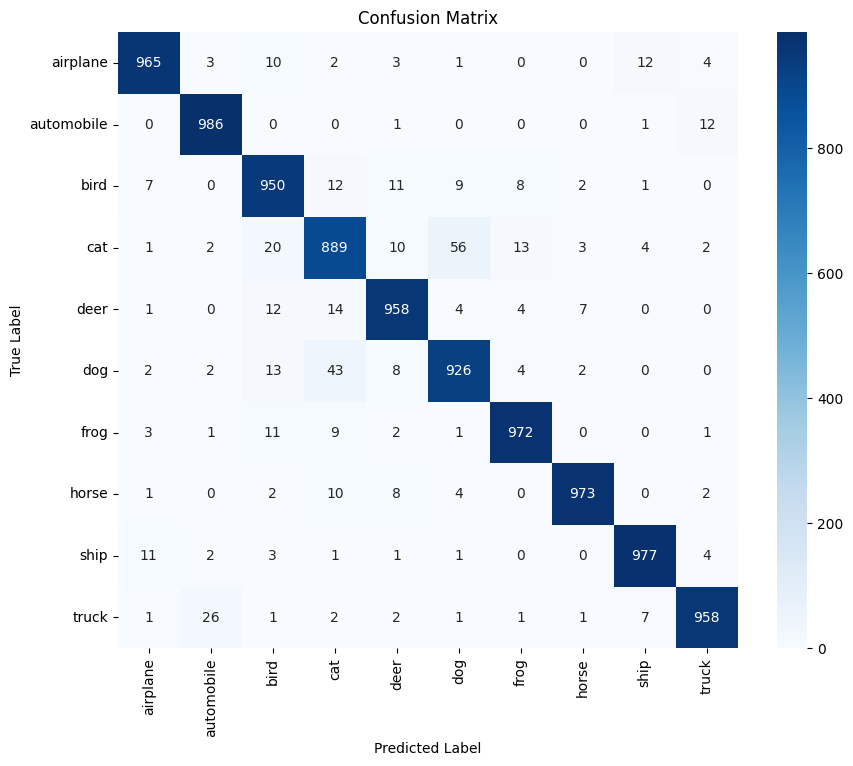

<Figure size 640x480 with 0 Axes>

In [44]:
# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cifar10_labels.values(), yticklabels=cifar10_labels.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
plt.savefig("final-conf-matrix.jpg")

In [31]:
# Generate submission file
pred_labels = []
mean_tensor = torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 3, 1, 1).to(device)
std_tensor = torch.tensor([0.2023, 0.1994, 0.2010]).view(1, 3, 1, 1).to(device)

for idx in range(len(test_images)):
    image = test_images[idx].reshape(32, 32, 3)
    tensor_image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float().to(device)
    tensor_image = (tensor_image / 255.0 - mean_tensor) / std_tensor
    
    with torch.no_grad():
        output = model(tensor_image)
        pred_label_idx = output.argmax(dim=1).item()
        pred_labels.append(pred_label_idx)

submission_df = pd.DataFrame({"ID": test_ids, "Labels": pred_labels})
submission_df.to_csv("submission_final_03-14.csv", index=False)
print("Submission file saved as submission_final_03-14.csv")

Submission file saved as submission_final_03-14.csv
